# Starbucks Capstone Challenge

In [123]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib import dates 
import locale
% matplotlib inline

In [124]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [125]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.use_inf_as_na = False

In [126]:
def amount_format(x):
    locale.setlocale(locale.LC_ALL, '')
    locale._override_localeconv = {'mon_thousands_sep': "'"}
    return locale.format('%.0f', x, grouping=True, monetary=True)

In [5]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

axis = {'fontsize':14}

annotation_vert = {'fontsize':12, 'ha':'center'}
annotation_hot = {'fontsize':12, 'ha':'left'}

In [6]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [9]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [10]:
print(profile.shape)
print(portfolio.shape)
print(transcript.shape)

(17000, 5)
(10, 6)
(306534, 4)


## Data cleaning

### Profile

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
print('Number of customers:', profile.shape[0])
print('Number of colunms:', profile.shape[1])

Number of customers: 17000
Number of colunms: 5


Check missing values

In [13]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [15]:
profile[profile['gender'].isnull()].head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


There are some records with empty "gender" and "income" fields and odd age of 118 year. 
I mark such records and fill missing values with mean.

In [16]:
avg_age = profile[profile['age']!=118]['age'].mean()
avg_income = profile[profile['age']!=118]['income'].mean()

profile.became_member_on = pd.to_datetime(profile.became_member_on.astype(int), format='%Y%m%d')

profile['missing_values'] = np.where(profile['age']==118,1, 0)
profile['age'] = np.where(profile['age']==118,avg_age, profile['age'])
profile['gender'] = np.where(pd.isna(profile['gender']),'O', profile['gender'])
profile['income'] = np.where(pd.isna(profile['income']),avg_income, profile['income'])
profile_cleaned = profile[profile['missing_values']==0]

Let's check the structure of customers by gender 

In [17]:
profile_by_gender = profile_cleaned[['id', 'gender']].groupby(by='gender').agg({'id': lambda x: len(x) / len(profile_cleaned) * 100}).reset_index()

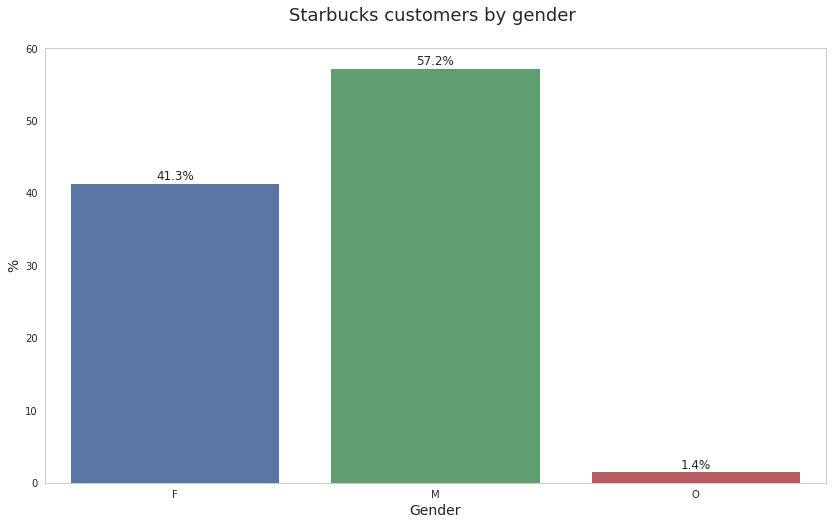

In [18]:
ax = sns.barplot(x="gender", y="id", data=profile_by_gender)#, estimator=lambda x: x / 100)


for i in range(0, len(profile_by_gender)):
    ax.text(i, profile_by_gender['id'].iloc[i]+0.5,  '{:.1%}'.format(profile_by_gender['id'].iloc[i]/100), **annotation_vert)

plt.grid(False)
plt.xlabel("Gender", **axis)
plt.ylabel("%", **axis)

plt.title('Starbucks customers by gender \n', size=18);
#plt.savefig('Plots/customers_by_gender.png')

It's also interesting to see dynamic users' registration over time.

In [19]:
profile_by_date = profile.set_index(['became_member_on'])
profile_by_date = profile_by_date.sort_index()

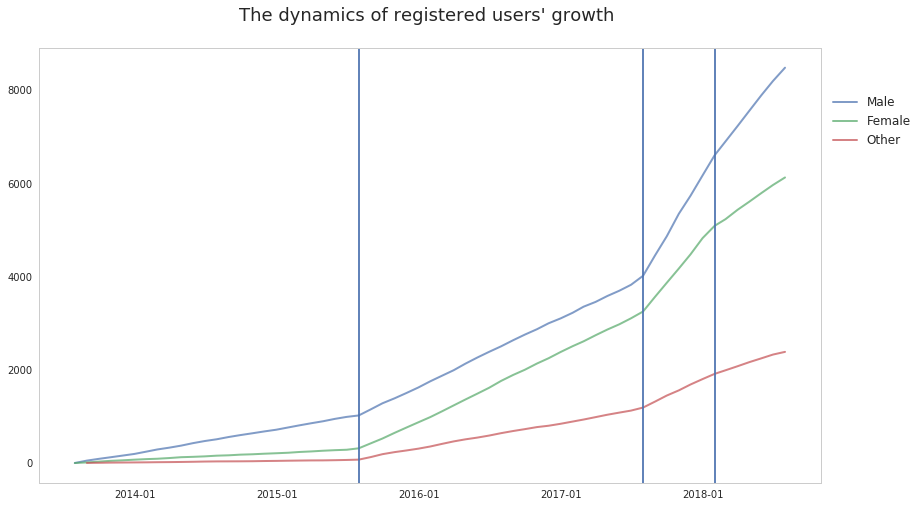

In [20]:
fig, ax = plt.subplots()
myFmt = dates.DateFormatter("%Y-%m")
plt.grid(False)

plt.plot(profile_by_date[profile_by_date.gender=='M']['age'].resample('M').count().cumsum(), linewidth=2, alpha=0.7, label='Male')
plt.plot(profile_by_date[profile_by_date.gender=='F']['age'].resample('M').count().cumsum(), linewidth=2, alpha=0.7, label='Female')
plt.plot(profile_by_date[profile_by_date.gender=='O']['age'].resample('M').count().cumsum(), linewidth=2, alpha=0.7, label='Other')

ax.xaxis.set_major_formatter(myFmt); 

plt.title("The dynamics of registered users' growth \n", size=18)

plt.axvline(x=pd.Timestamp('2015-08-01'))
plt.axvline(x=pd.Timestamp('2017-08-01'))
plt.axvline(x=pd.Timestamp('2018-02-01'))


plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0., fontsize=12, facecolor="white");
#plt.savefig('Plots/registered_users_dynamics.png')

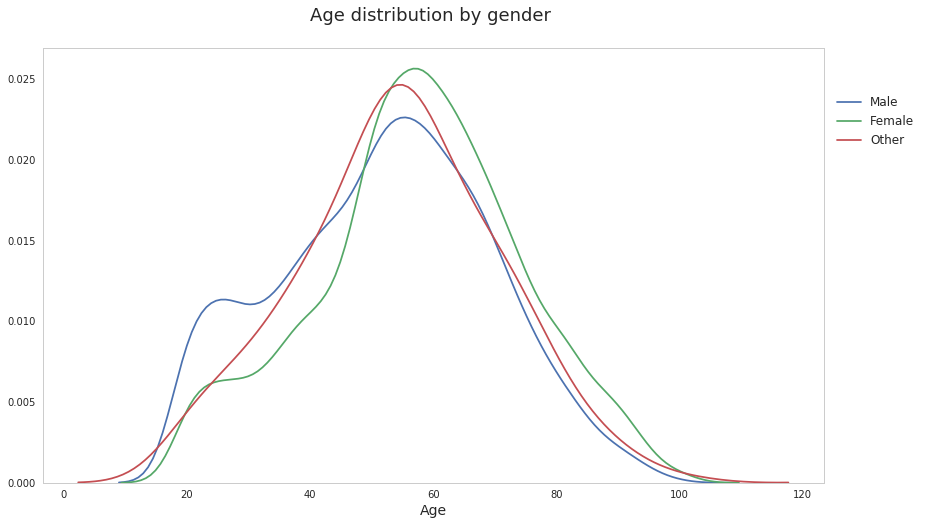

In [21]:
sns.distplot(profile_cleaned[profile_cleaned['gender']=='M']['age'], hist=False, kde_kws={"shade": False}, label="Male");
sns.distplot(profile_cleaned[profile_cleaned['gender']=='F']['age'], hist=False, kde_kws={"shade": False}, label="Female");
sns.distplot(profile_cleaned[profile_cleaned['gender']=='O']['age'], hist=False, kde_kws={"shade": False}, label="Other");

plt.grid(False)
plt.title('Age distribution by gender \n', size=18)
plt.xlabel("Age", **axis)

plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0., fontsize=12, facecolor="white");
#plt.savefig('Plots/age_distr_by_gender.png')

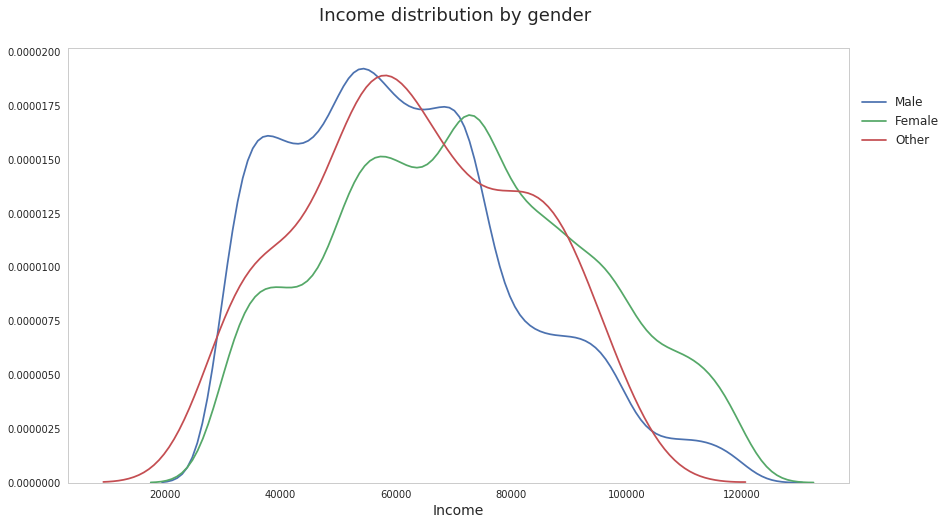

In [22]:
sns.distplot(profile[(profile['missing_values']==0) & (profile['gender']=='M')]['income'], hist=False, kde_kws={"shade": False}, label="Male");
sns.distplot(profile[(profile['missing_values']==0) & (profile['gender']=='F')]['income'], hist=False, kde_kws={"shade": False}, label="Female");
sns.distplot(profile[(profile['missing_values']==0) & (profile['gender']=='O')]['income'], hist=False, kde_kws={"shade": False}, label="Other");

plt.grid(False)
plt.title('Income distribution by gender \n', size=18)
plt.xlabel("Income", **axis)

plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0., fontsize=12, facecolor="white");
#plt.savefig('Plots/income_distr_by_gender.png')

In [23]:
profile_cleaned = profile[profile['age']!=118]

In [24]:
profile_cleaned.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
missing_values      0
dtype: int64

In [25]:
profile_cleaned.set_index('id', inplace=True)

In [26]:
profile_cleaned.head()

,age,became_member_on,gender,income,missing_values
id,,,,,
68be06ca386d4c31939f3a4f0e3dd783,54.393524,2017-02-12,O,65404.991568,1
0610b486422d4921ae7d2bf64640c50b,55.000000,2017-07-15,F,112000.000000,0
38fe809add3b4fcf9315a9694bb96ff5,54.393524,2018-07-12,O,65404.991568,1
78afa995795e4d85b5d9ceeca43f5fef,75.000000,2017-05-09,F,100000.000000,0
a03223e636434f42ac4c3df47e8bac43,54.393524,2017-08-04,O,65404.991568,1


### Portfolio

In [27]:
print(portfolio.shape)

(10, 6)


In [28]:
portfolio[['offer_type', 'id', 'reward']].groupby(by=["offer_type", 'reward']).agg({'id':'count'})

id
offer_type    reward    
bogo          5        2
              10       2
discount      2        2
              3        1
              5        1
informational 0        2

In [29]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Portfolio dataset is tiny, but here we can clean "channels" field to prepear for further analysis

In [30]:
channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)

In [31]:
portfolio_cleaned = portfolio.join(channels)
portfolio_cleaned.drop(['channels'], axis=1, inplace=True)
portfolio_cleaned.set_index('id', inplace=True)

In [32]:
portfolio_cleaned

,difficulty,duration,offer_type,reward,email,mobile,social,web
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,1,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,1
2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,discount,3,1,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,1
5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,1,1,0
f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1,1


### Transcript

In [33]:
print(transcript.shape)

(306534, 4)


In [34]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [36]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [37]:
transcript[['event', 'person']].groupby(by=["event"]).agg({'person':'count'}).sort_values(by='person', ascending=False).reset_index()

,event,person
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


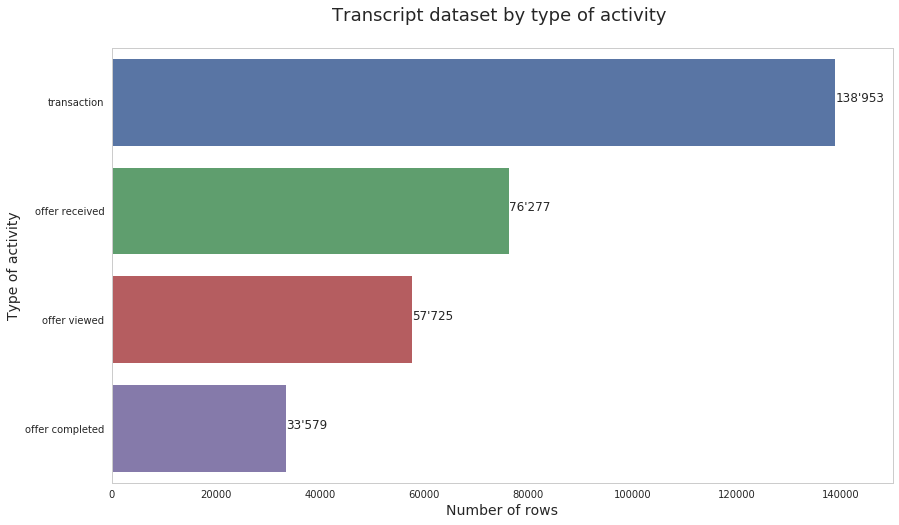

In [38]:
transcript_by_type = transcript[['event', 'person']].groupby(by=["event"]).agg({'person':'count'}).sort_values(by='person', ascending=False).reset_index()
ax = sns.barplot(x="person", y="event", data=transcript_by_type)

for i in range(0, len(transcript_by_type)):
    ax.text(transcript_by_type['person'].iloc[i]+0.5, i, amount_format(transcript_by_type['person'].iloc[i]), **annotation_hot)

plt.grid(False)
plt.xlim(0, 150000)
plt.xlabel("Number of rows", **axis)
plt.ylabel("Type of activity", **axis)

plt.title('Transcript dataset by type of activity \n', size=18);
#plt.savefig('Plots/transcript_by_activity.png')

In [39]:
# Add a column in datatime format. As we don't have information about starting point, we assume that it starts at 01/01/2019 in 00:00:00 
transcript['date']=pd.to_datetime(transcript.time, origin=pd.Timestamp('01/01/2019 00:00:00'), unit='h')

In [40]:
transcript[transcript.event=='offer received'].head()

,event,person,time,value,date
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2019-01-01
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2019-01-01
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2019-01-01
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2019-01-01
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2019-01-01


In [41]:
transcript[transcript.event=='offer viewed'].head()

,event,person,time,value,date
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},2019-01-01
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},2019-01-01
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2019-01-01
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},2019-01-01
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},2019-01-01


In [52]:
transcript[transcript.event=='transaction'].head()

,event,person,time,value,date
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},2019-01-01
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},2019-01-01
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},2019-01-01
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},2019-01-01
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},2019-01-01


In [53]:
transcript[transcript.event=='offer completed'].head()

,event,person,time,value,date
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2019-01-01
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,2019-01-01
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,2019-01-01
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,2019-01-01
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,2019-01-01


In [54]:
transcript[transcript.event=='offer completed'].head().value.values

array([{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5},
       {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10},
       {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}], dtype=object)

For "offer completed" event, there are two values: offer_id and reward

It looks like the dataset contains three general categories of events: 
- offers recieved and viewed (with offer_id as value), 
- offers completed (with offer_id and reward), 
- transaction related (with amount). 

I split this dataset in three different subsets depending on the category.

In [55]:
def transcript_value(df):
    '''
    This function creates addition column(s) from dictionary type of "value" colunm 
    INPUT: df - (pandas dataframe) with "value" colunm, which contains a dictionary-like string
    OUTPUT: df - (pandas dataframe) with additional column(s) from dictionary value
    '''

    value_col = df.value.apply(pd.Series)
    df = df.join(value_col)
    df.drop(['value'], axis=1, inplace=True)
    
    return df

#### Transactions

In [56]:
transactions = transcript[transcript.event=='transaction']

In [57]:
transactions.shape

(138953, 5)

In [58]:
transactions = transcript_value(transactions)

In [59]:
transactions.head()

,event,person,time,date,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,2019-01-01,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2019-01-01,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,2019-01-01,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,2019-01-01,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,2019-01-01,18.97


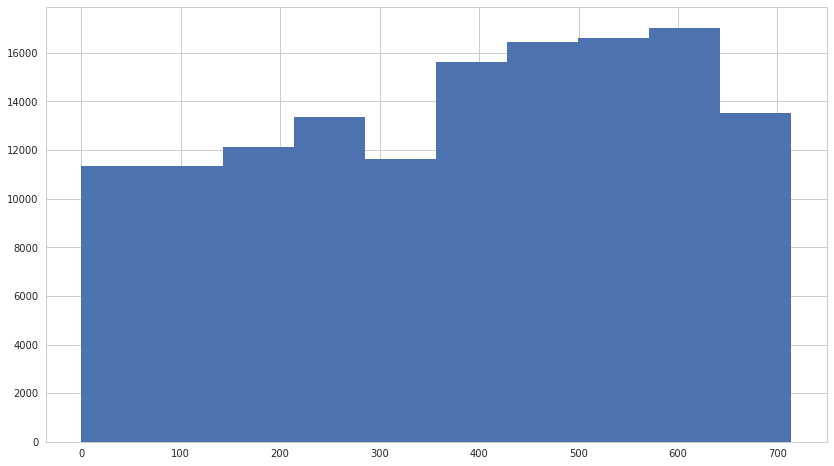

In [60]:
transactions.time.hist();

In [61]:
transactions.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [62]:
transactions.time.describe()

count    138953.000000
mean        381.584334
std         201.697230
min           0.000000
25%         210.000000
50%         402.000000
75%         552.000000
max         714.000000
Name: time, dtype: float64

In [63]:
transactions.head(5)

,event,person,time,date,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,2019-01-01,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2019-01-01,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,2019-01-01,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,2019-01-01,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,2019-01-01,18.97


Having the information regarding all transaction, we can summarize it and add to profile_cleaned, as an additional information about the customers.

In [64]:
total_spending = transactions.groupby(['person']).agg({'person':'count', 'amount': ['sum', np.mean, np.median], 'date':lambda x: x.dt.day.nunique()})
total_spending.columns = ['_'.join(col) for col in total_spending.columns]
total_spending.rename(index=str, columns={'person_count': 'total_transactions',
                                          'amount_sum': 'total_amount', 
                                          'amount_mean': 'average_bill', 
                                          'amount_median': 'median_bill', 
                                          'date_<lambda>': 'visits'}, inplace=True)
profile_cleaned = profile_cleaned.merge(total_spending, left_index=True, right_index=True, how='left').fillna(0)

In [65]:
transactions.set_index(['person', 'date'], inplace=True)

#### Offers receieved

We'll check the whole life cycle the offer: received - viewed - completed in the valid period. 
Apart this standard life cycle, the could be several different options:
1. Offer was received, but not viewed and not completed.
2. Offer was received, not viewed but completed.
3. Offer was received, viewed but not completed.
3. Offer was received, viewed and completed.

Received offer will be a starting point. 

In [66]:
offers_received = transcript[transcript.event.isin(['offer received'])].copy()

In [67]:
offers_received.shape

(76277, 5)

In [68]:
offers_received = transcript_value(offers_received)

In [69]:
offers_received.shape

(76277, 5)

In [70]:
offers_received = pd.merge(offers_received, portfolio_cleaned, left_on=['offer id'], right_index=True, how='left') 
offers_received['duration']=pd.to_timedelta(offers_received['duration'], unit='D')
offers_received['expired'] = offers_received['date'] + offers_received['duration']

In [71]:
offers_received['id']=offers_received.person.str.cat(offers_received['offer id'], sep='-')
offers_received.set_index(['id'], inplace=True)
offers_received.drop(['event','person','offer id'], axis=1, inplace=True)

In [72]:
offers_received.head()

,time,date,difficulty,duration,offer_type,reward,email,mobile,social,web,expired
id,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4b65b9aebfe6a799e6d9,0,2019-01-01,5,7 days,bogo,5,1,1,0,1,2019-01-08
a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc45b7b9fa7c272da2e1d7,0,2019-01-01,20,10 days,discount,5,1,0,0,1,2019-01-11
e2127556f4f64592b11af22de27a7932-2906b810c7d4411798c6938adc9daaa5,0,2019-01-01,10,7 days,discount,2,1,1,0,1,2019-01-08
8ec6ce2a7e7949b1bf142def7d0e0586-fafdcd668e3743c1bb461111dcafc2a4,0,2019-01-01,10,10 days,discount,2,1,1,1,1,2019-01-11
68617ca6246f4fbc85e91a2a49552598-4d5c57ea9a6940dd891ad53e9dbe8da0,0,2019-01-01,10,5 days,bogo,10,1,1,1,1,2019-01-06


#### Offers viewed

In [73]:
offers_viewed = transcript[transcript.event.isin(['offer viewed'])].copy()

In [74]:
offers_viewed.shape

(57725, 5)

In [75]:
offers_viewed = transcript_value(offers_viewed)

In [76]:
offers_viewed['id']=offers_viewed.person.str.cat(offers_viewed['offer id'], sep='-')
offers_viewed.set_index(['id', 'date'], inplace=True)
offers_viewed.drop(['event','person','offer id'], axis=1, inplace=True)

In [77]:
offers_viewed.head()

,,time
id,date,
389bc3fa690240e798340f5a15918d5c-f19421c1d4aa40978ebb69ca19b0e20d,2019-01-01,0
d1ede868e29245ea91818a903fec04c6-5a8bc65990b245e5a138643cd4eb9837,2019-01-01,0
102e9454054946fda62242d2e176fdce-4d5c57ea9a6940dd891ad53e9dbe8da0,2019-01-01,0
02c083884c7d45b39cc68e1314fec56c-ae264e3637204a6fb9bb56bc8210ddfd,2019-01-01,0
be8a5d1981a2458d90b255ddc7e0d174-5a8bc65990b245e5a138643cd4eb9837,2019-01-01,0


#### Offers completed

In [78]:
offers_completed = transcript[transcript.event=='offer completed'].copy()

In [79]:
offers_completed.shape

(33579, 5)

In [80]:
offers_completed = transcript_value(offers_completed)

In [81]:
offers_completed.head(10)

,event,person,time,date,offer_id,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2019-01-01,2906b810c7d4411798c6938adc9daaa5,2
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,2019-01-01,fafdcd668e3743c1bb461111dcafc2a4,2
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,2019-01-01,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,2019-01-01,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,2019-01-01,4d5c57ea9a6940dd891ad53e9dbe8da0,10
12717,offer completed,227f2d69e46a4899b70d48182822cff6,0,2019-01-01,4d5c57ea9a6940dd891ad53e9dbe8da0,10
12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,2019-01-01,2298d6c36e964ae4a3e7e9706d1fb8c2,3
12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0,2019-01-01,f19421c1d4aa40978ebb69ca19b0e20d,5
12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2019-01-01,2906b810c7d4411798c6938adc9daaa5,2
12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,2019-01-01,4d5c57ea9a6940dd891ad53e9dbe8da0,10


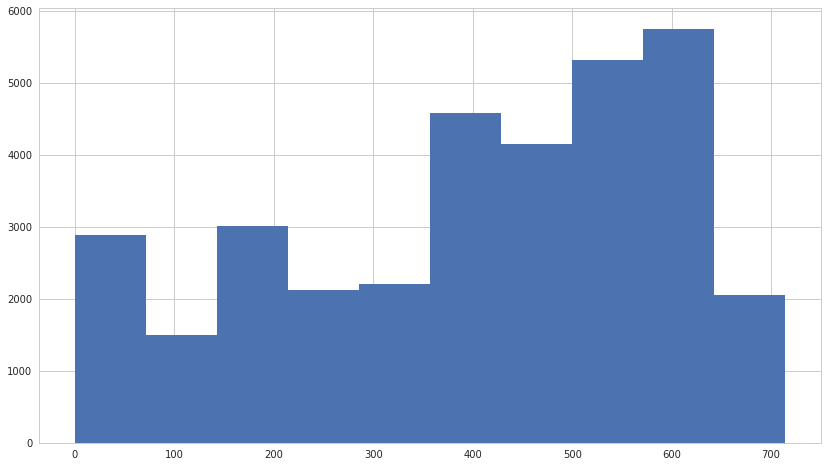

In [82]:
offers_completed.time.hist();

In [83]:
offers_completed['id']=offers_completed.person.str.cat(offers_completed['offer_id'], sep='-')
offers_completed.set_index(['id', 'date'], inplace=True)
offers_completed.drop(['event','person','offer_id'], axis=1, inplace=True)

In [84]:
offers_completed.sort_index(inplace=True)
offers_completed.head()

,,time,reward
id,date,,
0009655768c64bdeb2e877511632db8f-2906b810c7d4411798c6938adc9daaa5,2019-01-25 00:00:00,576,2
0009655768c64bdeb2e877511632db8f-f19421c1d4aa40978ebb69ca19b0e20d,2019-01-18 06:00:00,414,5
0009655768c64bdeb2e877511632db8f-fafdcd668e3743c1bb461111dcafc2a4,2019-01-23 00:00:00,528,2
0011e0d4e6b944f998e987f904e8c1e5-0b1e1539f2cc45b7b9fa7c272da2e1d7,2019-01-25 00:00:00,576,5
0011e0d4e6b944f998e987f904e8c1e5-2298d6c36e964ae4a3e7e9706d1fb8c2,2019-01-11 12:00:00,252,3


### Offer's life stages

Now, when we have information when an offer was received, viewed and completed, we can create a life cycle for each client/offer combination.

In [85]:
def when_veiwed(unique_id, recieved, expired):
    '''
    The function checks the closest view time, 
    in absence of unique id to time value after the recieved offert return pd.NaT
    
    INPUT: unique Persion/Offer id in a format "person"-"offer_id"
    OUTPUT: the closest time after time of recieve. In absence of the closest time return pd.NaT
    '''
    try:
        output = offers_viewed.loc[unique_id].truncate(before=recieved, after=expired).index.min()
    except:
        output = pd.NaT
    
    return output

In [86]:
offers_received['viewed']=offers_received.apply(lambda x: when_veiwed(x.name, x.date, x.expired), axis=1)

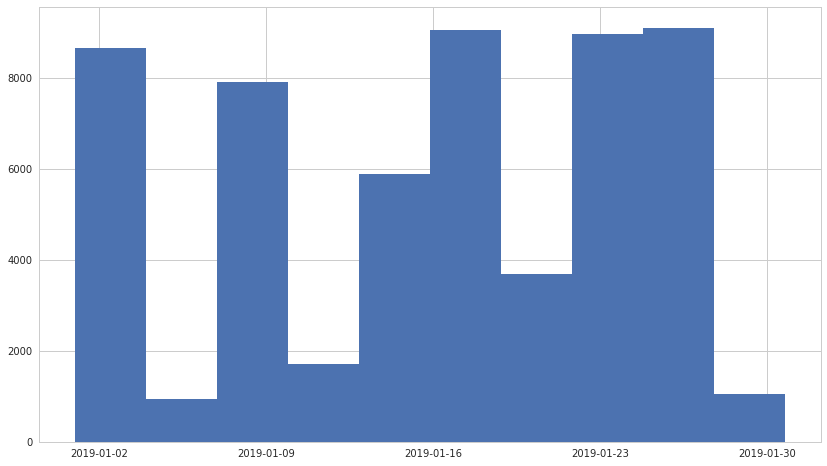

In [87]:
offers_received.viewed.hist();

In [93]:
def when_completed(unique_id, recieved, viewed, expired):
    '''
    The function checks the closest complete time, 
    in absence of unique id to time value after the viewed offer return pd.NaT
    
    INPUT: unique Persion/Offer id in a format "person"-"offer_id"
    OUTPUT: the closest time after time of recieve. In absence of the closest time return pd.NaT as time and zero as reward.
    '''
    try:
        completed =  offers_completed.loc[unique_id].truncate(before=pd.Series([recieved, viewed]).max(), after=expired).index.min()
        reward = offers_completed.loc[(unique_id, completed), 'reward'].values[0]      
       
        output = (completed, reward) 
    except:
        output = (pd.NaT, 0)
    
    return output

In [94]:
completed_info = offers_received.apply(lambda x: when_completed(x.name, x.date, x.viewed, x.expired), axis=1)

In [95]:
offers_received['completed']=completed_info.str[0]
offers_received['reward']=completed_info.str[1]

In [98]:
offers_received.reset_index(inplace=True)

In [101]:
#offers_received[['person','offer_id']] = offers_received.id.str.split('-', expand=True)
#offers_received.drop(['id'], axis=1, inplace=True)

In [102]:
offers_received.head()

,level_0,index,time,date,difficulty,duration,offer_type,reward,email,mobile,social,web,expired,viewed,completed,person,offer_id
0,0,0,0,2019-01-01,5,7 days,bogo,0,1,1,0,1,2019-01-08,2019-01-01 06:00:00,NaT,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,1,1,0,2019-01-01,20,10 days,discount,0,1,0,0,1,2019-01-11,2019-01-01 06:00:00,NaT,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,2,0,2019-01-01,10,7 days,discount,0,1,1,0,1,2019-01-08,2019-01-01 18:00:00,NaT,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
3,3,3,0,2019-01-01,10,10 days,discount,0,1,1,1,1,2019-01-11,2019-01-01 12:00:00,NaT,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4
4,4,4,0,2019-01-01,10,5 days,bogo,0,1,1,1,1,2019-01-06,2019-01-04 12:00:00,NaT,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0


In [103]:
df = offers_received.copy()

As a target offer, we'll use offers with the following criterias:
- Offer was recieved by user
- Offer was viewed
- Offer was complete with the period (duration) of the offer

Let's call "used" offer

In [104]:
df['used'] = np.where((df['date']<=df['completed'])&(df['expired']>=df['completed'])&(df['viewed']!=pd.NaT), 1, 0)
df['viewed_on_time'] = np.where((df['viewed']<=df['expired'])&(df['viewed']>=df['date'])&(df['viewed']!=pd.NaT), 1, 0)

In [105]:
df['time_to_view']=((df.viewed-df.date)/np.timedelta64(1, 'h')).fillna(999)
df['time_to_complete']=((df.completed-df.viewed)/np.timedelta64(1, 'h')).fillna(999)

In [106]:
# Merge offers dataset with Profile dataset to get more general information regarding customers
df = df.merge(profile_cleaned, left_on='person',  right_index=True, how='left')

In [107]:
df['member_since'] = df.became_member_on.dt.year

In [108]:
df['offer_transaction']=pd.merge(df, transactions, left_on=['person','completed'], right_index=True, how='left')[['amount']].values
df['offer_transaction'].fillna(0, inplace=True)

#### Starbucks custering

As the nature of the Informational offer is different and requires another metrics (there is no reward and no completed definition here), I have decided to drop it.

In [109]:
# Select Bogo and discount offeres
df_UL = df[['person', 'offer_type', 'age', 'gender', 'income', 'member_since', 'missing_values', 'total_amount', 'average_bill', 'median_bill', 'total_transactions', 'visits',
                    'difficulty', 'offer_transaction', 'time_to_view', 'viewed_on_time', 'time_to_complete', 'reward', 'used']][df.offer_type.isin(['bogo', 'discount'])]

# Group data by user
df_UL= df_UL.groupby(by=['person', 'age', 'gender', 'income', 'member_since','missing_values', 'average_bill', 'median_bill', 'total_amount', 'visits','total_transactions']) \
                .agg({'used':['sum','count'],'reward': 'sum', 'offer_transaction':'mean', 'viewed_on_time':'sum', 'time_to_view':'mean', 'time_to_complete':'mean'})

df_UL.columns = ['_'.join(col) for col in df_UL.columns]
df_UL = df_UL.reset_index()

#Additionl metrics
df_UL['offers_per_visit']=(df_UL['used_sum']/df_UL['visits']).fillna(0)
df_UL['viewed_ratio']=(df_UL['viewed_on_time_sum']/df_UL['used_count']).fillna(0)
df_UL['response_ratio']=(df_UL['used_sum']/df_UL['used_count']).fillna(0)

df_UL['cost_ratio']=(df_UL['reward_sum']/df_UL['total_amount']).fillna(0)
df_UL['offer/total']=(df_UL['offer_transaction_mean']/df_UL['average_bill']).fillna(0)

# Final feature selection for Clustering
df_model = df_UL[['average_bill', 'visits', 'viewed_ratio', 'response_ratio', 'cost_ratio', 'offers_per_visit']]

In [110]:
#General information about the final features
df_model.describe()

,average_bill,visits,viewed_ratio,response_ratio,cost_ratio,offers_per_visit
count,16928.000000,16928.000000,16928.000000,16928.0,16928.0,16928.0
mean,13.351690,7.041647,0.770941,0.0,0.0,0.0
std,16.021651,3.869387,0.259839,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,3.040625,4.000000,0.600000,0.0,0.0,0.0
50%,11.425606,7.000000,0.800000,0.0,0.0,0.0
75%,20.247187,10.000000,1.000000,0.0,0.0,0.0
max,451.470000,23.000000,1.000000,0.0,0.0,0.0


In [111]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Data scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_model)

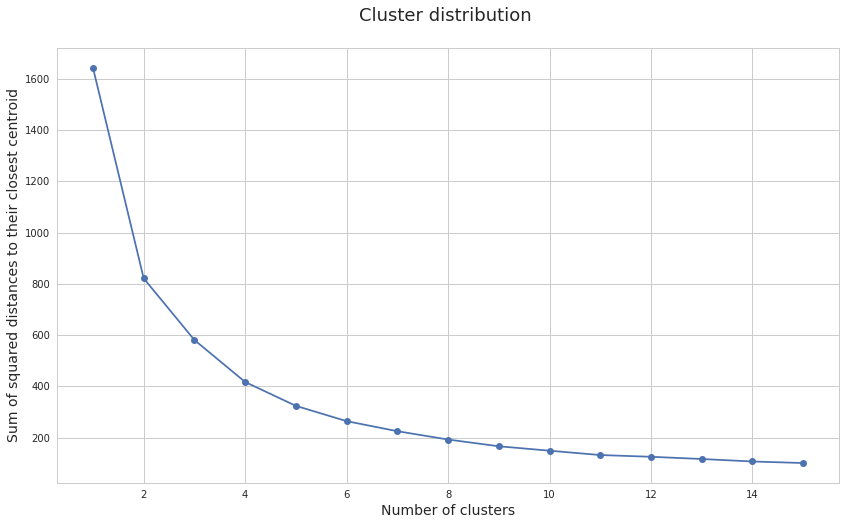

In [112]:
clusers_to_check = 15
results_inertia = []

clusters = range(1,clusers_to_check+1)
    
for k in clusters:
    kmean = KMeans(n_clusters=k)
    kmean.fit(scaled_data)
    
    results_inertia.append(kmean.inertia_)

plt.plot(clusters, results_inertia, marker='o')

plt.xlabel("Number of clusters", **axis)
plt.ylabel("Sum of squared distances to their closest centroid", **axis)

plt.title('Cluster distribution \n', size=18);

According to the Elbow method, the optimal number of clusters would be 4 or 5. For my further, I used 5 to get more different groups for detailed analysis.

In [113]:
kmean = KMeans(n_clusters=5)
kmean.fit(scaled_data)
df_UL['cluster']=kmean.predict(scaled_data)

In [114]:
# General information regading clusters

grouped_by_cluster = df_UL[['cluster', 'person', 'total_amount', 'age', 'income', 'reward_sum', 'visits', 'used_count', 'total_transactions','viewed_on_time_sum', 'used_sum']] \
                            .groupby(by=["cluster"]) \
                            .agg({'person':'count', 'used_count':'sum', 'used_sum': 'sum',
                                  'total_amount':'sum', 'reward_sum':'sum', 'visits':'sum',
                                 'total_transactions':'sum', 'viewed_on_time_sum':'sum'}).reset_index()

grouped_by_cluster['average_bill']=grouped_by_cluster.total_amount / grouped_by_cluster.total_transactions
grouped_by_cluster['cost_ratio']=grouped_by_cluster.reward_sum / grouped_by_cluster.total_amount
grouped_by_cluster['response_ratio']=grouped_by_cluster.used_sum / grouped_by_cluster.used_count
grouped_by_cluster['viewed_ratio']=grouped_by_cluster.viewed_on_time_sum / grouped_by_cluster.used_count
grouped_by_cluster['offers_to_visits']=grouped_by_cluster.used_sum / grouped_by_cluster.visits

grouped_by_cluster

,cluster,person,used_count,used_sum,total_amount,reward_sum,visits,total_transactions,viewed_on_time_sum,average_bill,cost_ratio,response_ratio,viewed_ratio,offers_to_visits
0,0,4200,15859,0,297591.28,0,19868.0,21862.0,10303,13.612262,0.0,0.0,0.649663,0.0
1,1,4509,14438,0,334828.56,0,19455.0,21151.0,14358,15.830389,0.0,0.0,0.994459,0.0
2,2,2956,12156,0,426214.17,0,33264.0,40592.0,8319,10.499955,0.0,0.0,0.684353,0.0
3,3,1832,6323,0,117677.75,0,9623.0,10741.0,1728,10.955940,0.0,0.0,0.273288,0.0
4,4,3431,12266,0,594965.74,0,36991.0,44228.0,12223,13.452242,0.0,0.0,0.996494,0.0


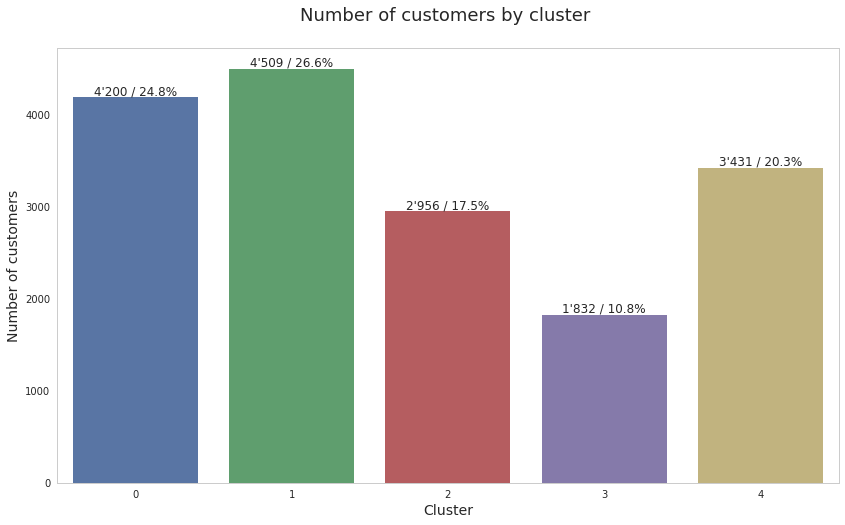

In [115]:
total_customers = grouped_by_cluster.person.sum()

ax = sns.barplot(x="cluster", y="person", estimator=np.sum, ci=None, data=grouped_by_cluster);

for i in range(0, len(grouped_by_cluster)):
    value = grouped_by_cluster['person'].iloc[i]
    text = str(amount_format(value))+" / "+str('{:.1%}'.format(value/total_customers))
    ax.text(i, grouped_by_cluster['person'].iloc[i]+20, text, **annotation_vert)

plt.grid(False)    
plt.xlabel("Cluster", **axis)
plt.ylabel("Number of customers", **axis)

plt.title('Number of customers by cluster \n', size=18);

The number of customer is almost equally distributed by clusters.

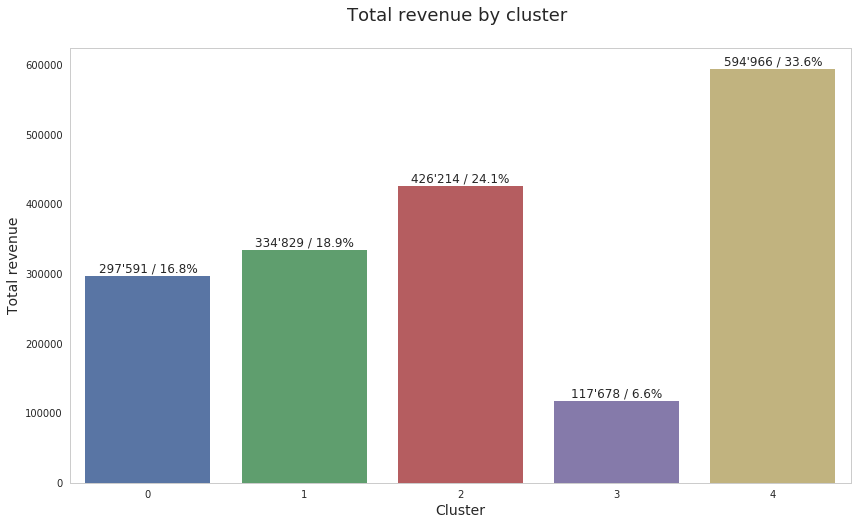

In [116]:
total_revenue = grouped_by_cluster.total_amount.sum()

ax = sns.barplot(x="cluster", y="total_amount", estimator=np.sum, ci=None, data=df_UL);

for i in range(0, len(grouped_by_cluster)):
    value = grouped_by_cluster['total_amount'].iloc[i]
    text = str(amount_format(value))+" / "+str('{:.1%}'.format(value/total_revenue))
    ax.text(i, grouped_by_cluster['total_amount'].iloc[i]+5000, text, **annotation_vert)

plt.grid(False)
plt.xlabel("Cluster", **axis)
plt.ylabel("Total revenue", **axis)

plt.title('Total revenue by cluster \n', size=18);

Almost half of the revenue is generated by Cluster 0 and another 45% by Clusters 1 and 2. Let's check the difference in behaviour by each cluster.

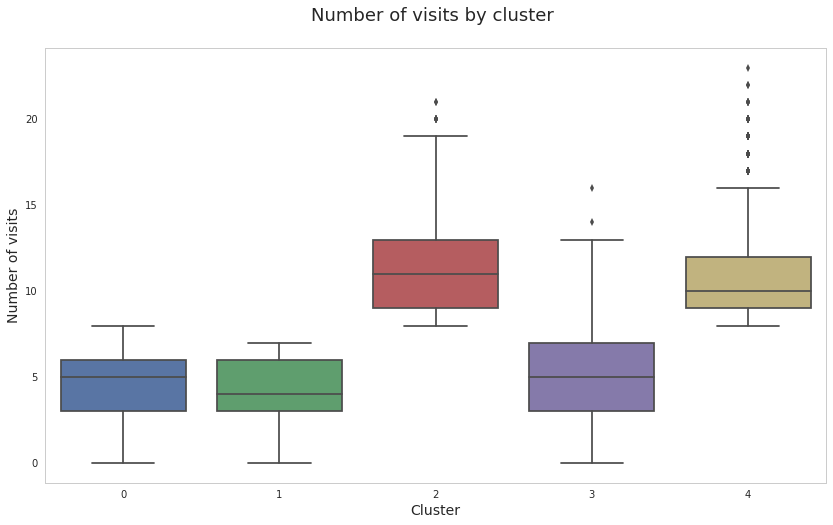

In [117]:
ax = sns.boxplot(y='visits', x="cluster", data=df_UL)

plt.grid(False)
plt.xlabel("Cluster", **axis)
plt.ylabel("Number of visits", **axis)

plt.title('Number of visits by cluster \n', size=18);

Text(0,0.5,'Average bill')

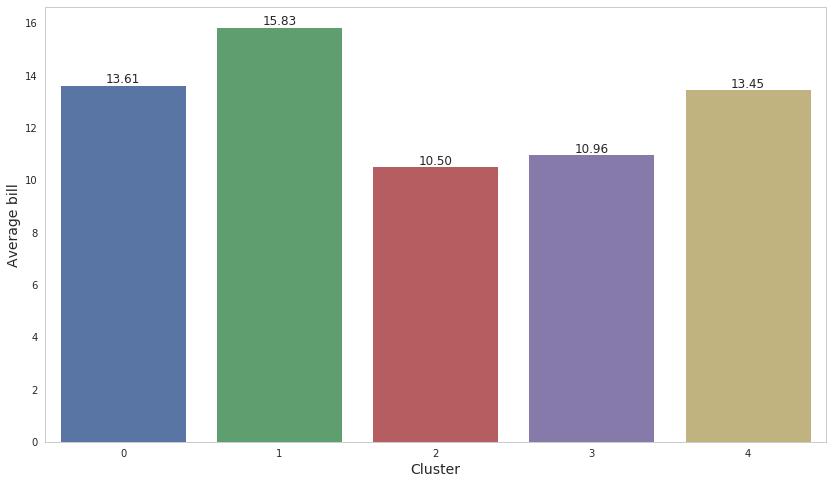

In [119]:
ax = sns.barplot(x="cluster", y="average_bill", estimator=np.sum, ci=None, data=grouped_by_cluster);

for i in range(0, len(grouped_by_cluster)):
    value = grouped_by_cluster['average_bill'].iloc[i]
    text = str('{:.2f}'.format(value))
    ax.text(i, grouped_by_cluster['average_bill'].iloc[i]+0.10, text, **annotation_vert)

plt.grid(False)
plt.xlabel("Cluster", **axis)
plt.ylabel("Average bill", **axis)


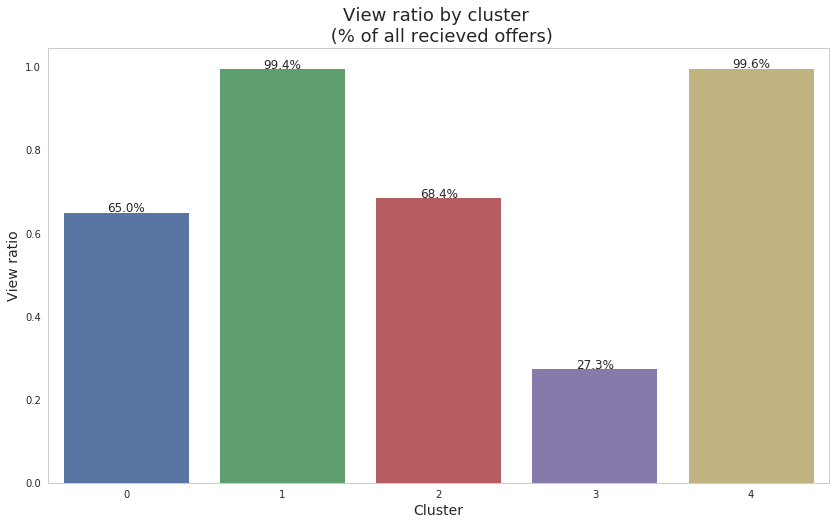

In [120]:
ax = sns.barplot(x="cluster", y="viewed_ratio", ci=None, data=grouped_by_cluster);

for i in range(0, len(grouped_by_cluster)):
    text = '{:.1%}'.format(grouped_by_cluster['viewed_ratio'].iloc[i])
    ax.text(i, grouped_by_cluster['viewed_ratio'].iloc[i]+0.001, text, **annotation_vert)



plt.grid(False)
plt.xlabel("Cluster", **axis)
plt.ylabel("View ratio", **axis)

plt.title('View ratio by cluster \n (% of all recieved offers)', size=18);

# Results:
I was managed to find 5 different groups with unsupervised machine learning algorithm (K-Means). With this information, a company can implement some different marketing campaigns for each group depending on the general strategy.

For this project, we have data only for the one-month period, but it would be interesting to analyze a longer period, like several months or even years. Then we can see the structure (clusters) changes over time and could also estimate the impact of changing offer’s parameters like frequency of campaign, offers’ difficulty, duration and reward.